In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, classification_report, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import plotly.express as px

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

In [2]:
# Load the dataset
df = pd.read_csv("enhanced_ollama_models.csv")

In [3]:
df.head(1)

,name,description,pulls,tags,updated,capabilities,size_variants,url,parameter_sizes,context_window,model_type,license_info,base_model,performance_benchmarks,hardware_requirements,specialty_domain,release_info,quantization_support
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,NaN,https://ollama.com/library/deepseek-r1,671b,128K; 160K,Vision; Code; Math,Apache 2.0; MIT License; mit,Qwen-2; Llama3,NaN,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,coding; math; reasoning; scientific,3,No


In [4]:
df = df.drop(columns=["base_model", "size_variants","url","performance_benchmarks","license_info","release_info"])

In [5]:
df.head(1)

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,specialty_domain,quantization_support
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,coding; math; reasoning; scientific,No


In [6]:
# Function to parse pull counts from string format
def parse_pulls(s):
    if isinstance(s, str):
        if 'M' in s:
            return float(s.replace('M','')) * 1000000
        if 'K' in s:
            return float(s.replace('K','')) * 1000
        if ',' in s:
            return float(s.replace(',',''))
        try:
            return float(s)
        except:
            return np.nan
    return np.nan

# Apply pull conversion
df['pulls_num'] = df['pulls'].apply(parse_pulls)

In [7]:
# Convert updated time to days
def parse_updated_days(update_str):
    if pd.isna(update_str):
        return 0
    
    # Extract number
    num_match = re.search(r'(\d+)', update_str)
    if not num_match:
        return 0
    
    num = int(num_match.group(1))
    
    # Convert to days
    if 'week' in update_str.lower():
        return num * 7
    elif 'month' in update_str.lower():
        return num * 30
    elif 'year' in update_str.lower():
        return num * 365
    else:
        return num

df['updated_days'] = df['updated'].apply(parse_updated_days)

In [8]:
# Function to extract capabilities
def get_capabilities(cap_str):
    if pd.isnull(cap_str):
        return []
    return [c.strip().lower() for c in str(cap_str).split(';') if c.strip()]

# Get all unique capabilities
all_caps = set()
for caps in df['capabilities'].dropna():
    all_caps.update(get_capabilities(caps))

print("Unique capabilities found:", sorted(all_caps))

# Create binary columns for each capability
for cap in all_caps:
    df[f'capabilities_{cap}'] = df['capabilities'].apply(lambda x: cap in get_capabilities(x))

# Check capability distribution
print("\nCapability distribution:")
for cap in sorted(all_caps):
    count = df[f'capabilities_{cap}'].sum()
    print(f"{cap}: {count} cap ({count/len(df)*100:.1f}%)")

Unique capabilities found: ['embedding', 'thinking', 'tools', 'vision']

Capability distribution:
embedding: 9 cap (5.1%)
thinking: 4 cap (2.3%)
tools: 41 cap (23.4%)
vision: 13 cap (7.4%)


In [9]:
df.head(2)

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,specialty_domain,quantization_support,pulls_num,updated_days,capabilities_tools,capabilities_embedding,capabilities_thinking,capabilities_vision
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,coding; math; reasoning; scientific,No,53400000.0,14,True,False,True,False
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,coding; math; reasoning; scientific,Yes,175800.0,14,False,False,False,False


In [10]:
# Function to extract capabilities
def get_model_type(model_type_str):
    if pd.isnull(model_type_str):
        return []
    return [c.strip().lower() for c in str(model_type_str).split(';') if c.strip()]

# Get all unique capabilities
all_model_type = set()
for model in df['model_type'].dropna():
    all_model_type.update(get_model_type(model))

print("Unique Model Type found:", sorted(all_model_type))

# Create binary columns for each capability
for model in all_model_type:
    df[f'model_type_{model}'] = df['model_type'].apply(lambda x: model in get_model_type(x))

# Check capability distribution
print("\n Model Type distribution:")
for model in sorted(all_model_type):
    count = df[f'model_type_{model}'].sum()
    print(f"{model}: {count} models ({count/len(df)*100:.1f}%)")

Unique Model Type found: ['chat', 'code', 'embedding', 'math', 'reasoning', 'text', 'vision']

 Model Type distribution:
chat: 41 models (23.4%)
code: 71 models (40.6%)
embedding: 12 models (6.9%)
math: 41 models (23.4%)
reasoning: 32 models (18.3%)
text: 109 models (62.3%)
vision: 175 models (100.0%)


In [11]:
df.head(2)

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,...,capabilities_embedding,capabilities_thinking,capabilities_vision,model_type_vision,model_type_chat,model_type_code,model_type_text,model_type_embedding,model_type_reasoning,model_type_math
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,...,False,True,False,True,False,True,False,False,False,True
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,...,False,False,False,True,False,True,False,False,False,True


In [12]:
# Function to extract capabilities
def get_speciality_domain(speciality_domain_str):
    if pd.isnull(speciality_domain_str):
        return []
    return [c.strip().lower() for c in str(speciality_domain_str).split(';') if c.strip()]

# Get all unique capabilities
all_speciality_domain = set()
for domain in df['specialty_domain'].dropna():
    all_speciality_domain.update(get_speciality_domain(domain))

print("Unique Domain Type found:", sorted(all_speciality_domain))

# Create binary columns for each capability
for domain in all_speciality_domain:
    df[f'domain_type_{domain}'] = df['specialty_domain'].apply(lambda x: domain in get_speciality_domain(x))

# Check capability distribution
print("\n Speciality Domain Type distribution:")
for domain in sorted(all_speciality_domain):
    count = df[f'domain_type_{domain}'].sum()
    print(f"{domain}: {count} domains ({count/len(df)*100:.1f}%)")

Unique Domain Type found: ['chat', 'coding', 'embedding', 'finance', 'function_calling', 'legal', 'math', 'medical', 'reasoning', 'scientific', 'summarization', 'translation', 'vision']

 Speciality Domain Type distribution:
chat: 42 domains (24.0%)
coding: 86 domains (49.1%)
embedding: 16 domains (9.1%)
finance: 5 domains (2.9%)
function_calling: 48 domains (27.4%)
legal: 7 domains (4.0%)
math: 42 domains (24.0%)
medical: 6 domains (3.4%)
reasoning: 53 domains (30.3%)
scientific: 44 domains (25.1%)
summarization: 9 domains (5.1%)
translation: 92 domains (52.6%)
vision: 126 domains (72.0%)


In [13]:
df.head(2)

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,...,domain_type_summarization,domain_type_math,domain_type_scientific,domain_type_coding,domain_type_embedding,domain_type_finance,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,...,False,True,True,True,False,False,False,True,False,False
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,...,False,True,True,True,False,False,False,True,False,False


In [14]:
df [ df['domain_type_coding'] ] 

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,...,domain_type_summarization,domain_type_math,domain_type_scientific,domain_type_coding,domain_type_embedding,domain_type_finance,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,...,False,True,True,True,False,False,False,True,False,False
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,...,False,True,True,True,False,False,False,True,False,False
2,gemma3,"The current, most capable model that runs on a...",8.8M,21,2 months ago,vision,27b; 1B; 4B; 12B; 27B,32K; 128K,Vision; Code; Math,3.3GB; 815MB; 8.1GB; 17GB; 43.9\n\n\nMB,...,False,True,True,True,False,False,False,True,False,False
3,qwen3,Qwen3 is the latest generation of large langua...,3.6M,35,1 month ago,tools;thinking,235b; 0.6B; 1.7B; 4B; 8B; 14B; 32B,40K,Vision; Code; Math,5.2GB; 523MB; 1.4GB; 2.6GB; 9.3GB; 19GB,...,False,True,False,True,False,False,False,True,False,True
5,llama3.1,Llama 3.1 is a new state-of-the-art model from...,97.9M,93,7 months ago,tools,405b; 70B; 405B,128K,Vision; Code; Math,4.9GB; 43GB; 243GB,...,False,True,False,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,nuextract,A 3.8B model fine-tuned on a private high-qual...,30.8K,17,11 months ago,NaN,3.8b; 3.8B; 13B; 34B,4K,Vision; Code; Math,2.2GB,...,False,True,False,True,False,False,False,True,False,True
164,granite3-guardian,The IBM Granite Guardian 3.0 2B and 8B models ...,26.9K,10,7 months ago,NaN,8b; 3B; 8B,8K,Vision; Code; Text,2.7GB; 5.8GB,...,False,False,True,True,False,False,False,False,True,True
167,open-orca-platypus2,Merge of the Open Orca OpenChat model and the ...,25.7K,17,1 year ago,NaN,13b; 13B,4K,Vision; Code; Chat,7.4GB; 16GB,...,False,False,False,True,False,False,True,False,False,False
170,sailor2,Sailor2 are multilingual language models made ...,23.4K,13,7 months ago,NaN,20b; 1B; 20B,32K,Vision; Text,5.2GB; 1.1GB; 12GB,...,False,False,True,True,False,False,False,False,False,True


In [15]:
def parse_hw(hw_str):
    if pd.isna(hw_str):
        return []
    # Find all numbers (GB or MB)
    matches = re.findall(r'([\d\.]+)\s*(GB|MB)', hw_str)
    # Convert all to GB
    gb_values = []
    for val, unit in matches:
        val = float(val)
        if unit == "MB":
            val = val / 1024
        gb_values.append(val)
    return gb_values

df['hw_gb_list'] = df['hardware_requirements'].apply(parse_hw)
df['hw_gb_min'] = df['hw_gb_list'].apply(lambda x: min(x) if x else np.nan)
df['hw_gb_max'] = df['hw_gb_list'].apply(lambda x: max(x) if x else np.nan)
df['hw_gb_mean'] = df['hw_gb_list'].apply(lambda x: np.mean(x) if x else np.nan)

In [16]:
df.head()

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,...,domain_type_embedding,domain_type_finance,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation,hw_gb_list,hw_gb_min,hw_gb_max,hw_gb_mean
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,...,False,False,False,True,False,False,"[5.2, 1.1, 4.7, 9.0, 20.0, 43.0]",1.100000,43.0,13.833333
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,...,False,False,False,True,False,False,"[7.5, 5.6, 0.06337890625]",0.063379,7.5,4.387793
2,gemma3,"The current, most capable model that runs on a...",8.8M,21,2 months ago,vision,27b; 1B; 4B; 12B; 27B,32K; 128K,Vision; Code; Math,3.3GB; 815MB; 8.1GB; 17GB; 43.9\n\n\nMB,...,False,False,False,True,False,False,"[3.3, 0.7958984375, 8.1, 17.0, 0.04287109375]",0.042871,17.0,5.847754
3,qwen3,Qwen3 is the latest generation of large langua...,3.6M,35,1 month ago,tools;thinking,235b; 0.6B; 1.7B; 4B; 8B; 14B; 32B,40K,Vision; Code; Math,5.2GB; 523MB; 1.4GB; 2.6GB; 9.3GB; 19GB,...,False,False,False,True,False,True,"[5.2, 0.5107421875, 1.4, 2.6, 9.3, 19.0]",0.510742,19.0,6.335124
4,qwen2.5vl,Flagship vision-language model of Qwen and als...,361.1K,17,1 month ago,vision,72b; 7B,125K,Vision; Math; Text,6.0GB; 3.2GB; 21GB; 49GB,...,False,True,False,False,False,True,"[6.0, 3.2, 21.0, 49.0]",3.200000,49.0,19.800000


In [17]:
def parse_context(context_str):
    if pd.isna(context_str):
        return []
    # Find all numbers (K = 1000 tokens)
    matches = re.findall(r'([\d\.]+)K', context_str)
    return [float(m) * 1000 for m in matches]

df['context_window_list'] = df['context_window'].apply(parse_context)
df['context_window_max'] = df['context_window_list'].apply(lambda x: max(x) if x else np.nan)
df['context_window_min'] = df['context_window_list'].apply(lambda x: min(x) if x else np.nan)
df['context_window_mean'] = df['context_window_list'].apply(lambda x: np.mean(x) if x else np.nan)

In [18]:
df.head()

,name,description,pulls,tags,updated,capabilities,parameter_sizes,context_window,model_type,hardware_requirements,...,domain_type_legal,domain_type_translation,hw_gb_list,hw_gb_min,hw_gb_max,hw_gb_mean,context_window_list,context_window_max,context_window_min,context_window_mean
0,deepseek-r1,DeepSeek-R1 is a family of open reasoning mode...,53.4M,35,2 weeks ago,tools;thinking,671b,128K; 160K,Vision; Code; Math,5.2GB; 1.1GB; 4.7GB; 9.0GB; 20GB; 43GB,...,False,False,"[5.2, 1.1, 4.7, 9.0, 20.0, 43.0]",1.100000,43.0,13.833333,"[128000.0, 160000.0]",160000.0,128000.0,144000.0
1,gemma3n,Gemma 3n models are designed for efficient exe...,175.8K,9,2 weeks ago,NaN,4b; 4B,32K,Vision; Code; Math,7.5GB; 5.6GB; 64.9\n\n\nMB,...,False,False,"[7.5, 5.6, 0.06337890625]",0.063379,7.5,4.387793,[32000.0],32000.0,32000.0,32000.0
2,gemma3,"The current, most capable model that runs on a...",8.8M,21,2 months ago,vision,27b; 1B; 4B; 12B; 27B,32K; 128K,Vision; Code; Math,3.3GB; 815MB; 8.1GB; 17GB; 43.9\n\n\nMB,...,False,False,"[3.3, 0.7958984375, 8.1, 17.0, 0.04287109375]",0.042871,17.0,5.847754,"[32000.0, 128000.0]",128000.0,32000.0,80000.0
3,qwen3,Qwen3 is the latest generation of large langua...,3.6M,35,1 month ago,tools;thinking,235b; 0.6B; 1.7B; 4B; 8B; 14B; 32B,40K,Vision; Code; Math,5.2GB; 523MB; 1.4GB; 2.6GB; 9.3GB; 19GB,...,False,True,"[5.2, 0.5107421875, 1.4, 2.6, 9.3, 19.0]",0.510742,19.0,6.335124,[40000.0],40000.0,40000.0,40000.0
4,qwen2.5vl,Flagship vision-language model of Qwen and als...,361.1K,17,1 month ago,vision,72b; 7B,125K,Vision; Math; Text,6.0GB; 3.2GB; 21GB; 49GB,...,False,True,"[6.0, 3.2, 21.0, 49.0]",3.200000,49.0,19.800000,[125000.0],125000.0,125000.0,125000.0


In [19]:
df = df.drop(columns=["hw_gb_list", "context_window_list","pulls","description","parameter_sizes","context_window","model_type","hardware_requirements","specialty_domain","capabilities","updated"])

In [20]:
df.head(1)

,name,tags,quantization_support,pulls_num,updated_days,capabilities_tools,capabilities_embedding,capabilities_thinking,capabilities_vision,model_type_vision,...,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation,hw_gb_min,hw_gb_max,hw_gb_mean,context_window_max,context_window_min,context_window_mean
0,deepseek-r1,35,No,53400000.0,14,True,False,True,False,True,...,False,True,False,False,1.1,43.0,13.833333,160000.0,128000.0,144000.0


In [21]:
bool_columns = df.select_dtypes(include=['bool']).columns

In [22]:
df.head(2)

,name,tags,quantization_support,pulls_num,updated_days,capabilities_tools,capabilities_embedding,capabilities_thinking,capabilities_vision,model_type_vision,...,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation,hw_gb_min,hw_gb_max,hw_gb_mean,context_window_max,context_window_min,context_window_mean
0,deepseek-r1,35,No,53400000.0,14,True,False,True,False,True,...,False,True,False,False,1.100000,43.0,13.833333,160000.0,128000.0,144000.0
1,gemma3n,9,Yes,175800.0,14,False,False,False,False,True,...,False,True,False,False,0.063379,7.5,4.387793,32000.0,32000.0,32000.0


In [23]:
df.columns

Index(['name', 'tags', 'quantization_support', 'pulls_num', 'updated_days',
       'capabilities_tools', 'capabilities_embedding', 'capabilities_thinking',
       'capabilities_vision', 'model_type_vision', 'model_type_chat',
       'model_type_code', 'model_type_text', 'model_type_embedding',
       'model_type_reasoning', 'model_type_math', 'domain_type_medical',
       'domain_type_vision', 'domain_type_chat', 'domain_type_summarization',
       'domain_type_math', 'domain_type_scientific', 'domain_type_coding',
       'domain_type_embedding', 'domain_type_finance',
       'domain_type_function_calling', 'domain_type_reasoning',
       'domain_type_legal', 'domain_type_translation', 'hw_gb_min',
       'hw_gb_max', 'hw_gb_mean', 'context_window_max', 'context_window_min',
       'context_window_mean'],
      dtype='object')

# What is the distribution of model popularity (pulls_num)

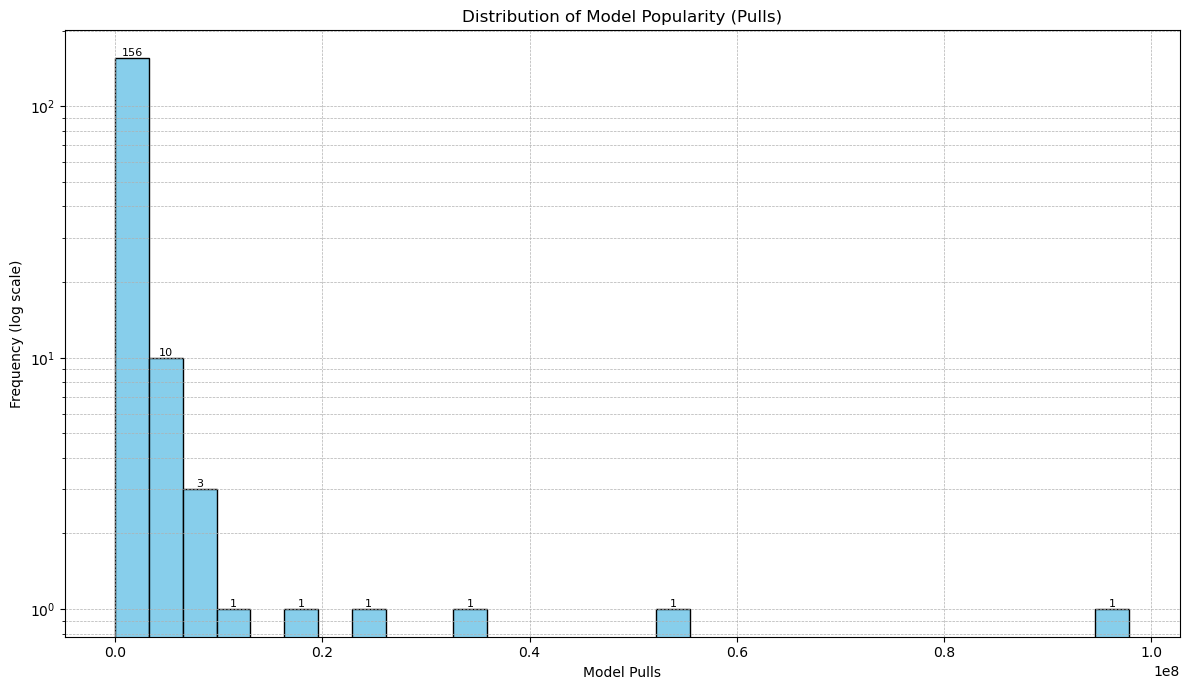

In [24]:
plt.figure(figsize=(12,7))
counts, bins, patches = plt.hist(df['pulls_num'], bins=30, log=True, color='skyblue', edgecolor='black')
plt.xlabel('Model Pulls')
plt.ylabel('Frequency (log scale)')
plt.title('Distribution of Model Popularity (Pulls)')

# Add value labels
for count, patch in zip(counts, patches):
    if count > 0:
        plt.text(patch.get_x() + patch.get_width()/2, count, int(count), ha='center', va='bottom', fontsize=8)

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Box Plot of Hardware Requirements Across Models

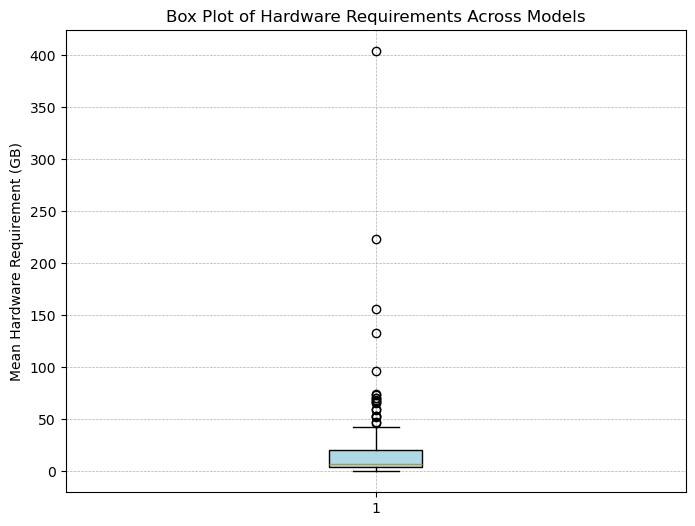

In [25]:
hw_gb_mean = df['hw_gb_mean'].dropna()

plt.figure(figsize=(8,6))
plt.boxplot(hw_gb_mean, vert=True, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.ylabel('Mean Hardware Requirement (GB)')
plt.title('Box Plot of Hardware Requirements Across Models')
plt.grid(True, ls="--", linewidth=0.5)
plt.show()

In [26]:
pd.set_option('display.max_columns', None)

In [27]:
df [ df['hw_gb_mean'] > 100 ]

,name,tags,quantization_support,pulls_num,updated_days,capabilities_tools,capabilities_embedding,capabilities_thinking,capabilities_vision,model_type_vision,model_type_chat,model_type_code,model_type_text,model_type_embedding,model_type_reasoning,model_type_math,domain_type_medical,domain_type_vision,domain_type_chat,domain_type_summarization,domain_type_math,domain_type_scientific,domain_type_coding,domain_type_embedding,domain_type_finance,domain_type_function_calling,domain_type_reasoning,domain_type_legal,domain_type_translation,hw_gb_min,hw_gb_max,hw_gb_mean,context_window_max,context_window_min,context_window_mean
29,deepseek-v3,5,No,1800000.0,180,False,False,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,404.0,404.0,404.0,4000.0,4000.0,4000.0
46,llama4,11,Yes,461800.0,28,True,False,False,True,True,False,True,False,False,False,True,False,False,False,False,True,False,True,False,False,False,True,True,False,67.0,245.0,156.0,128000.0,128000.0,128000.0
138,deepseek-v2.5,7,Yes,56500.0,300,False,False,False,False,True,True,True,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,133.0,133.0,133.0,4000.0,4000.0,4000.0
140,r1-1776,9,Yes,50200.0,120,False,False,False,False,True,False,False,False,False,True,True,False,False,False,False,True,True,False,False,True,False,True,False,False,43.0,404.0,223.5,128000.0,4000.0,66000.0


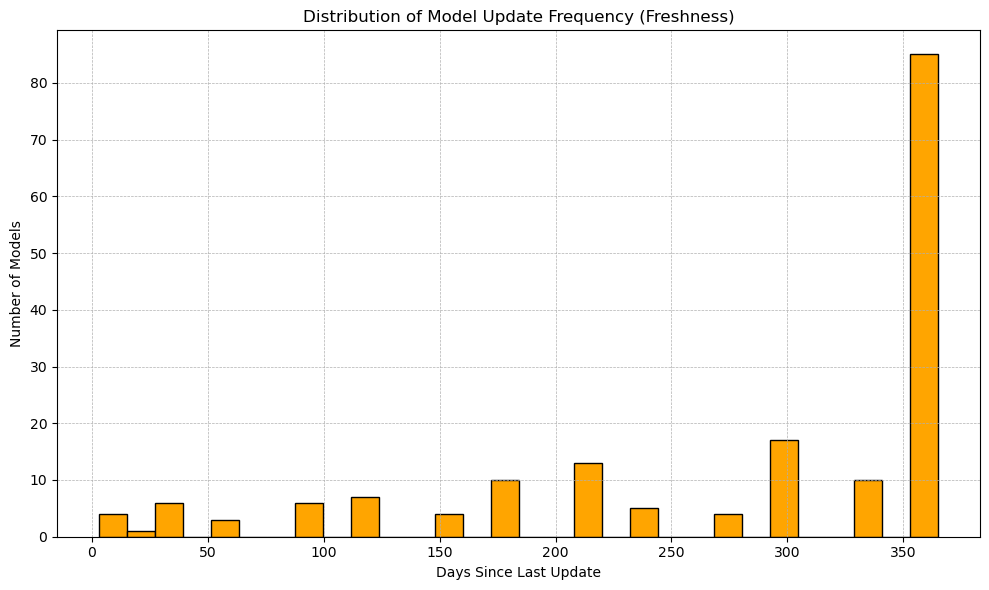

In [28]:
updated_days = df['updated_days'].dropna()

plt.figure(figsize=(10,6))
plt.hist(updated_days, bins=30, color='orange', edgecolor='black')
plt.xlabel('Days Since Last Update')
plt.ylabel('Number of Models')
plt.title('Distribution of Model Update Frequency (Freshness)')
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

In [29]:
fig = px.histogram(df, x='pulls_num', nbins=50, log_y=True, title='Model Popularity (Pulls)', labels={'pulls_num': 'Pulls'})
fig.update_layout(width=900, height=500)
fig.update_traces(marker_color='blue')
fig.show()

In [30]:
df['tag_count'] = pd.to_numeric(df['tags'], errors='coerce')
tag_counts = df['tag_count'].value_counts().sort_index()
fig.update_layout(width=900, height=500)
fig = px.bar(x=tag_counts.index, y=tag_counts.values, labels={'x': 'Number of Tags', 'y': 'Number of Models'}, title='Tag Count Distribution')
fig.show()

In [31]:
fig = px.histogram(df, x='updated_days', nbins=30, title='Model Update Frequency (days since update)')
fig.show()

In [32]:
import plotly.graph_objects as go
# Drop rows with no hardware requirements
df_valid = df.dropna(subset=['hw_gb_min', 'hw_gb_max'])

# Create side-by-side box plots
fig = go.Figure()
fig.add_trace(go.Box(y=df_valid['hw_gb_min'], name='Min Hardware (GB)', boxmean=True))
fig.add_trace(go.Box(y=df_valid['hw_gb_max'], name='Max Hardware (GB)', boxmean=True))

fig.update_layout(
    title='Distribution of Minimum vs Maximum Hardware Requirements (GB)',
    yaxis_title='Hardware Requirement (GB)',
    boxmode='group',  # Side-by-side
    width=1000,
    height=800
)
fig.show()

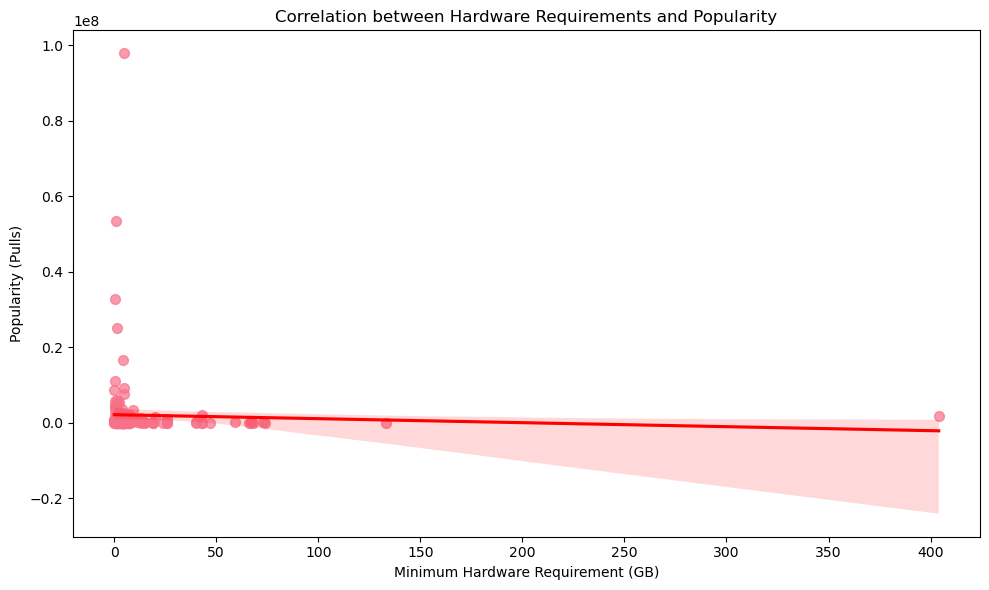

Correlation coefficient (min hardware vs popularity): -0.040


In [33]:
# Use pulls_num directly if already parsed
df['popularity'] = df['pulls_num']

# Drop rows with missing values
df_corr = df.dropna(subset=['hw_gb_min', 'popularity'])

# Scatter plot with trend line
plt.figure(figsize=(10, 6))
sns.regplot(x='hw_gb_min', y='popularity', data=df_corr, scatter_kws={'s': 50, 'alpha': 0.7}, line_kws={'color': 'red'})
plt.xlabel('Minimum Hardware Requirement (GB)')
plt.ylabel('Popularity (Pulls)')
plt.title('Correlation between Hardware Requirements and Popularity')
plt.tight_layout()
plt.show()

# Print correlation coefficient
corr_coef = np.corrcoef(df_corr['hw_gb_min'], df_corr['popularity'])[0, 1]
print(f"Correlation coefficient (min hardware vs popularity): {corr_coef:.3f}")

In [34]:

df['popularity'] = df['pulls_num']
# Drop rows with missing values
df_plot = df.dropna(subset=['hw_gb_min', 'popularity'])

# Scatter plot with trend line
fig = px.scatter(
    df_plot,
    x='hw_gb_min',
    y='popularity',
    hover_name='name',
    title='Correlation between Minimum Hardware Requirement (GB) and Popularity (Pulls)',
    labels={'min_hw_gb': 'Minimum Hardware Requirement (GB)', 'popularity': 'Popularity (Pulls)'},
    trendline='ols'
)

fig.update_layout(
    width=900,
    height=600,
    xaxis=dict(title='Minimum Hardware Requirement (GB)'),
    yaxis=dict(title='Popularity (Pulls)', type='log'),
    showlegend=False
)

fig.show()

In [35]:
# Drop rows with missing values
df_clean = df.dropna(subset=['updated_days', 'popularity'])

# Plotly scatter plot with trendline
fig = px.scatter(df_clean, x='updated_days', y='popularity',
                 hover_name='name',
                 trendline='ols',
                 labels={'updated_days': 'Model Age (days since update)', 'popularity': 'Popularity (pulls)'},
                 title='Model Age vs Popularity (Ollama Models)')
fig.show()

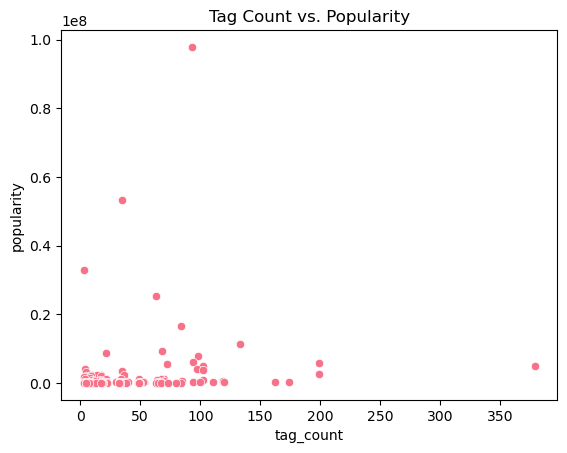

In [36]:
sns.scatterplot(x='tag_count', y='popularity', data=df)
plt.title('Tag Count vs. Popularity')
plt.show()

In [37]:
# Sort by popularity and select top 10
top10 = df.sort_values('popularity', ascending=False).head(10)

# Plotly horizontal bar chart
fig = px.bar(
    top10,
    x='popularity',
    y='name',
    orientation='h',
    title='Top 10 Most Popular Ollama Models',
    labels={'popularity': 'Popularity (Pulls)', 'name': 'Model Name'},
    text='popularity'
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    width=800,
    height=500
)
fig.show()

In [38]:
# Calculate efficiency (popularity per GB hardware)
df['efficiency'] = df['popularity'] / df['hw_gb_min'].round(2)

# Filter out models with missing or zero hardware requirements
df_eff = df[df['hw_gb_min'] > 0].dropna(subset=['efficiency']).round(2)

# Get top 10 efficient models
top10_eff = df_eff.sort_values('efficiency', ascending=False).head(10)

# Plotly horizontal bar chart
fig = px.bar(
    top10_eff,
    x='efficiency',
    y='name',
    orientation='h',
    title='Top 10 Most Efficient Ollama Models (Popularity per GB Hardware)',
    labels={'efficiency': 'Efficiency (Popularity / Min Hardware GB)', 'name': 'Model Name'},
    text='efficiency'
)

fig.update_layout(
    yaxis={'categoryorder':'total ascending'},
    width=900,
    height=500
)
fig.show()

In [39]:
# Sort models by maximum hardware requirement (descending)
top_resource_models = df.sort_values('hw_gb_max', ascending=False).head(10)

# Create horizontal bar chart
fig = px.bar(
    top_resource_models,
    x='hw_gb_max',
    y='name',
    orientation='h',
    text='hw_gb_max',
    title='Top 10 Most Resource-Intensive Ollama Models (Max Hardware GB)',
    labels={'hw_gb_max': 'Max Hardware Requirement (GB)', 'name': 'Model Name'}
)
fig.update_traces(texttemplate='%{text:.1f} GB', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [40]:
# Sort by freshness (lowest updated_days = most recent)
top_n = 10
fresh_df = df.sort_values('updated_days').head(top_n)

# Round values for readability
fresh_df['updated_days'] = fresh_df['updated_days'].round(0)

# Plotly horizontal bar chart
fig = px.bar(
    fresh_df,
    x='updated_days',
    y='name',
    orientation='h',
    title=f'Top {top_n} Most Recently Updated Ollama Models',
    labels={'updated_days': 'Days Since Last Update', 'name': 'Model Name'},
    text='updated_days'
)
fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='Days Since Last Update')
fig.show()

In [41]:
# List of capability columns
cap_cols = [col for col in df.columns if col.startswith('capabilities_')]

# Count capabilities for each model
df['capability_count'] = df[cap_cols].sum(axis=1)

# Get top 10 models by capability count
top10 = df.sort_values('capability_count', ascending=False).head(10)

# Plotly horizontal bar chart
fig = px.bar(
    top10,
    x='capability_count',
    y='name',
    orientation='h',
    title='Top 10 Models by Capability Count',
    labels={'capability_count': 'Number of Capabilities', 'name': 'Model Name'},
    text='capability_count'
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [42]:
# Filter out models with missing or zero hardware requirements
lightweight_df = df[df['hw_gb_min'] > 0].sort_values('hw_gb_min').head(10)

# Round hardware values for readability
lightweight_df['hw_gb_min'] = lightweight_df['hw_gb_min'].round(2)

# Plotly horizontal bar chart
fig = px.bar(
    lightweight_df,
    x='hw_gb_min',
    y='name',
    orientation='h',
    title='Top 10 Most Lightweight Ollama Models (Min Hardware GB)',
    labels={'hw_gb_min': 'Min Hardware Requirement (GB)', 'name': 'Model Name'},
    text='hw_gb_min'
)
fig.update_traces(texttemplate='%{text} GB', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [43]:
# Ensure context window columns are numeric
df['context_window_max'] = pd.to_numeric(df['context_window_max'], errors='coerce')

# Sort by largest context window
top_context_models = df.sort_values('context_window_max', ascending=False).head(10)

# Plot leaderboard
fig = px.bar(
    top_context_models,
    x='context_window_max',
    y='name',
    orientation='h',
    title='Top 10 Models with Largest Context Windows',
    labels={'context_window_max': 'Max Context Window', 'name': 'Model Name'},
    text='context_window_max'
)
fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'}, xaxis_title='Max Context Window')
fig.show()

In [44]:
# Ensure 'tag_count' column exists and is numeric
df['tag_count'] = pd.to_numeric(df['tag_count'], errors='coerce')

# Get top 10 models by tag count
top_tagged = df.sort_values('tag_count', ascending=False).head(10)

# Plotly horizontal bar chart
fig = px.bar(
    top_tagged,
    x='tag_count',
    y='name',  # Replace 'name' with the actual model name column if different
    orientation='h',
    title='Top 10 Most Tagged Ollama Models',
    labels={'tag_count': 'Tag Count', 'name': 'Model Name'},
    text='tag_count'
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [45]:
# List of domain columns (update as needed)
domain_columns = [col for col in df.columns if col.startswith('domain_type_')]

# Choose your ranking metric (e.g., popularity, efficiency)
ranking_metric = 'popularity'  # or 'efficiency', etc.

for domain in domain_columns:
    # Filter models for this domain
    domain_models = df[df[domain] == 1]  # or True, depending on your data

    # Sort by ranking metric
    top_models = domain_models.sort_values(by=ranking_metric, ascending=False).head(10)

    # Plot leaderboard
    fig = px.bar(
        top_models,
        x=ranking_metric,
        y='name',
        orientation='h',
        title=f'Top 10 Models for {domain.replace("domain_type_", "").capitalize()}',
        text=ranking_metric
    )
    fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
    fig.update_layout(yaxis={'categoryorder':'total ascending'})
    fig.show()

In [46]:
# Get top 10 most versatile models
top_versatile = df.sort_values('capability_count', ascending=False).head(10)

# Plotly horizontal bar chart
fig = px.bar(
    top_versatile,
    x='capability_count',
    y='name',
    orientation='h',
    title='Top 10 Most Versatile Ollama Models (by Capability Count)',
    labels={'capability_count': 'Number of Capabilities', 'name': 'Model Name'},
    text='capability_count'
)
fig.update_traces(texttemplate='%{text}', textposition='outside')
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

In [47]:
df.columns

Index(['name', 'tags', 'quantization_support', 'pulls_num', 'updated_days',
       'capabilities_tools', 'capabilities_embedding', 'capabilities_thinking',
       'capabilities_vision', 'model_type_vision', 'model_type_chat',
       'model_type_code', 'model_type_text', 'model_type_embedding',
       'model_type_reasoning', 'model_type_math', 'domain_type_medical',
       'domain_type_vision', 'domain_type_chat', 'domain_type_summarization',
       'domain_type_math', 'domain_type_scientific', 'domain_type_coding',
       'domain_type_embedding', 'domain_type_finance',
       'domain_type_function_calling', 'domain_type_reasoning',
       'domain_type_legal', 'domain_type_translation', 'hw_gb_min',
       'hw_gb_max', 'hw_gb_mean', 'context_window_max', 'context_window_min',
       'context_window_mean', 'tag_count', 'popularity', 'efficiency',
       'capability_count'],
      dtype='object')

In [48]:

# List of model type columns
model_type_cols = [
    'model_type_code', 'model_type_reasoning', 'model_type_vision',
    'model_type_embedding', 'model_type_chat', 'model_type_text', 'model_type_math'
]

# Count models for each type
type_counts = {col.replace('model_type_', '').capitalize(): df[col].sum() for col in model_type_cols}

# Prepare data for pie chart
pie_df = pd.DataFrame({
    'Model Type': list(type_counts.keys()),
    'Count': list(type_counts.values())
})

# Plot pie chart
fig = px.pie(
    pie_df,
    names='Model Type',
    values='Count',
    title='Breakdown of Model Types (Ollama Models)',
    hole=0.6
)
fig.show()

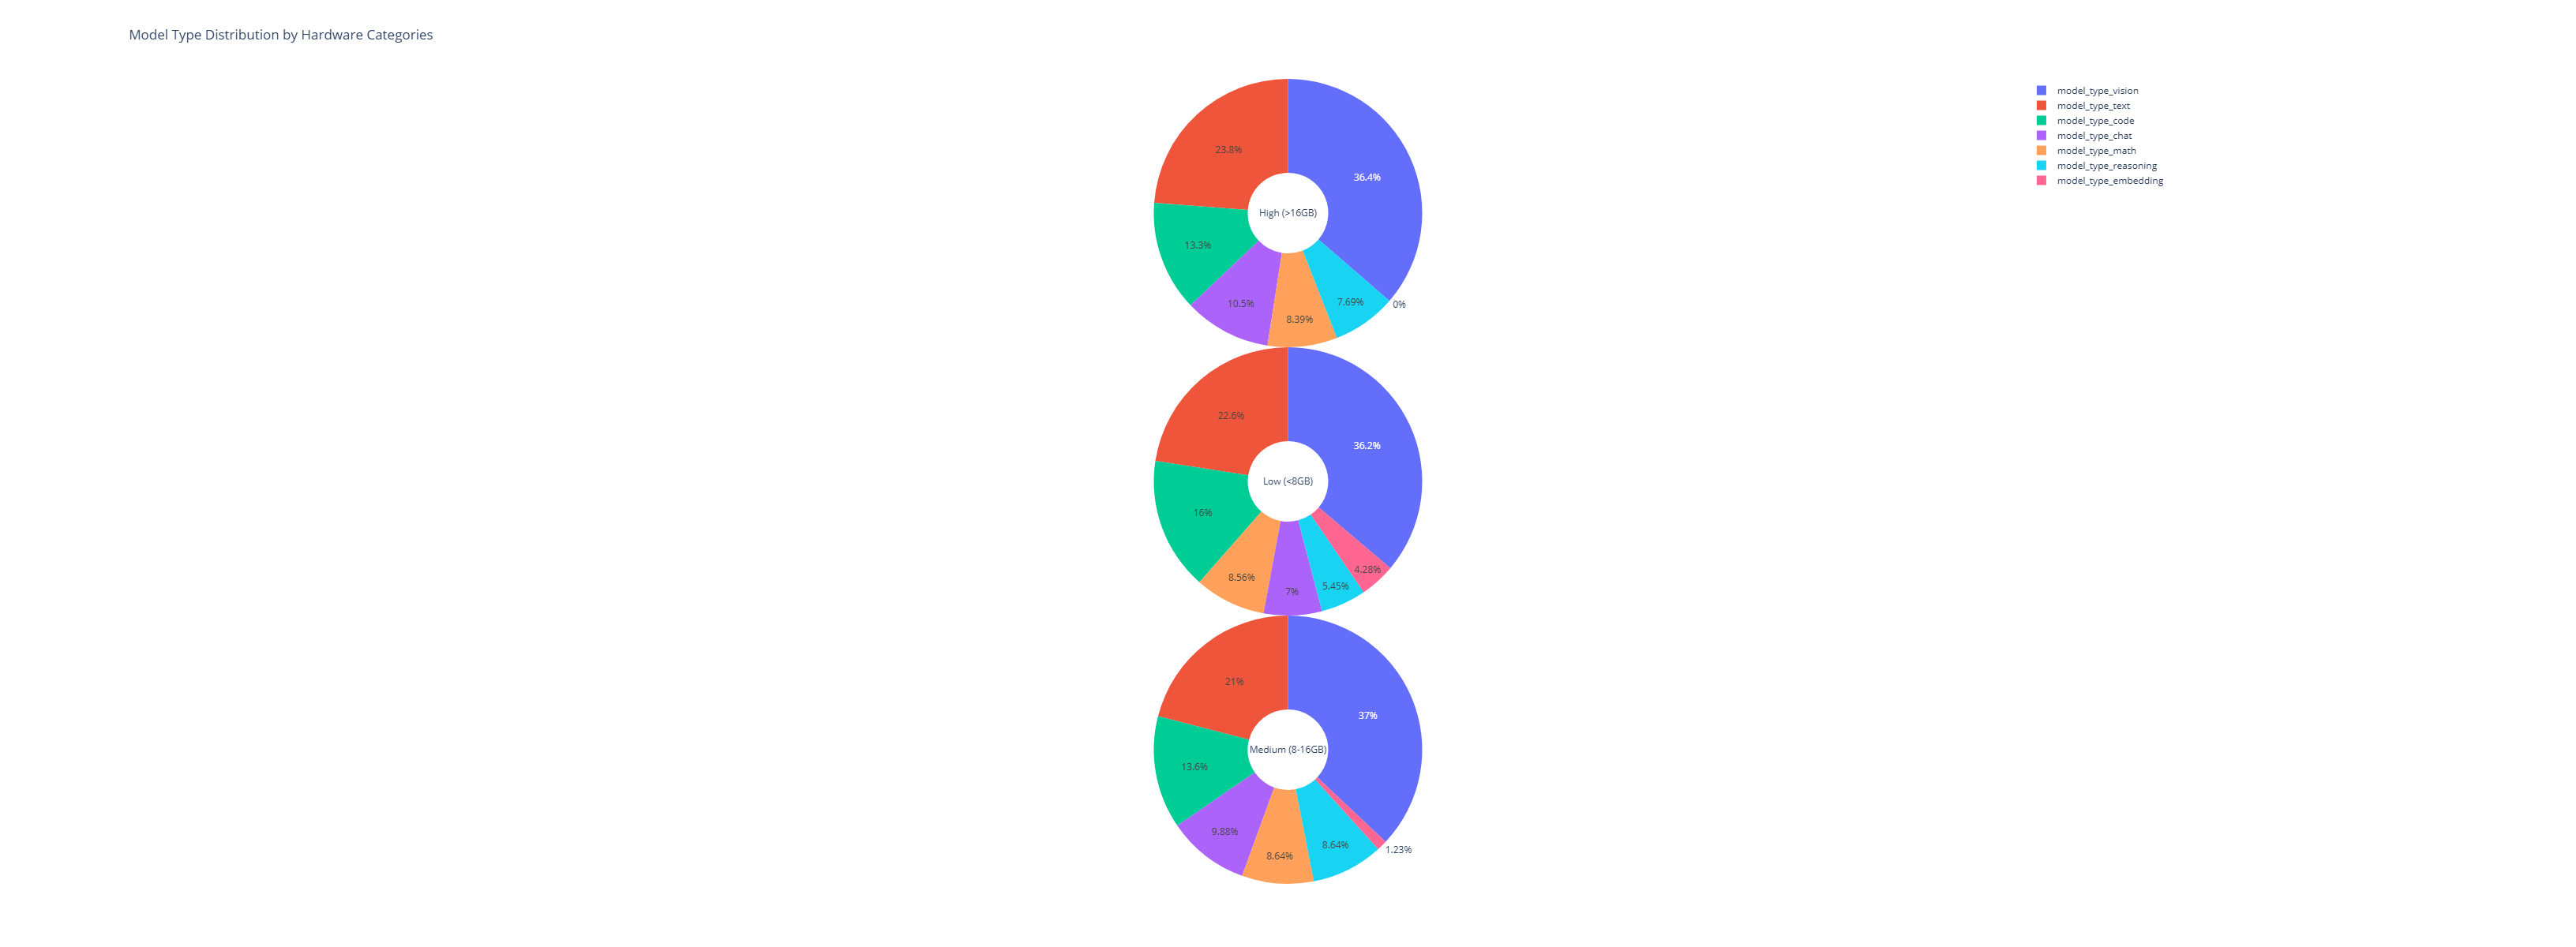

In [49]:
# Define hardware categories
def hw_category(gb):
    if gb < 8:
        return 'Low (<8GB)'
    elif gb < 16:
        return 'Medium (8-16GB)'
    else:
        return 'High (>16GB)'

df['hw_category'] = df['hw_gb_mean'].apply(hw_category)

# List of model type columns
model_type_cols = [
    'model_type_math', 'model_type_vision', 'model_type_text',
    'model_type_embedding', 'model_type_reasoning', 'model_type_chat', 'model_type_code'
]

# Prepare data for each hardware category
pie_data = {}
for cat in df['hw_category'].unique():
    subdf = df[df['hw_category'] == cat]
    # Count models for each type (sum of True/1 values)
    counts = {mt: subdf[mt].sum() for mt in model_type_cols}
    pie_data[cat] = counts

# Create stacked pie charts
fig = go.Figure()
for i, (cat, counts) in enumerate(pie_data.items()):
    fig.add_trace(go.Pie(
        labels=list(counts.keys()),
        values=list(counts.values()),
        name=cat,
        domain={'x': [0, 1], 'y': [i/len(pie_data), (i+1)/len(pie_data)]},
        title=cat,
        hole=0.3
    ))

fig.update_layout(
    title_text='Model Type Distribution by Hardware Categories',
    grid={'rows': len(pie_data), 'columns': 1},
    showlegend=True,
    height=400 * len(pie_data)
)
fig.show()

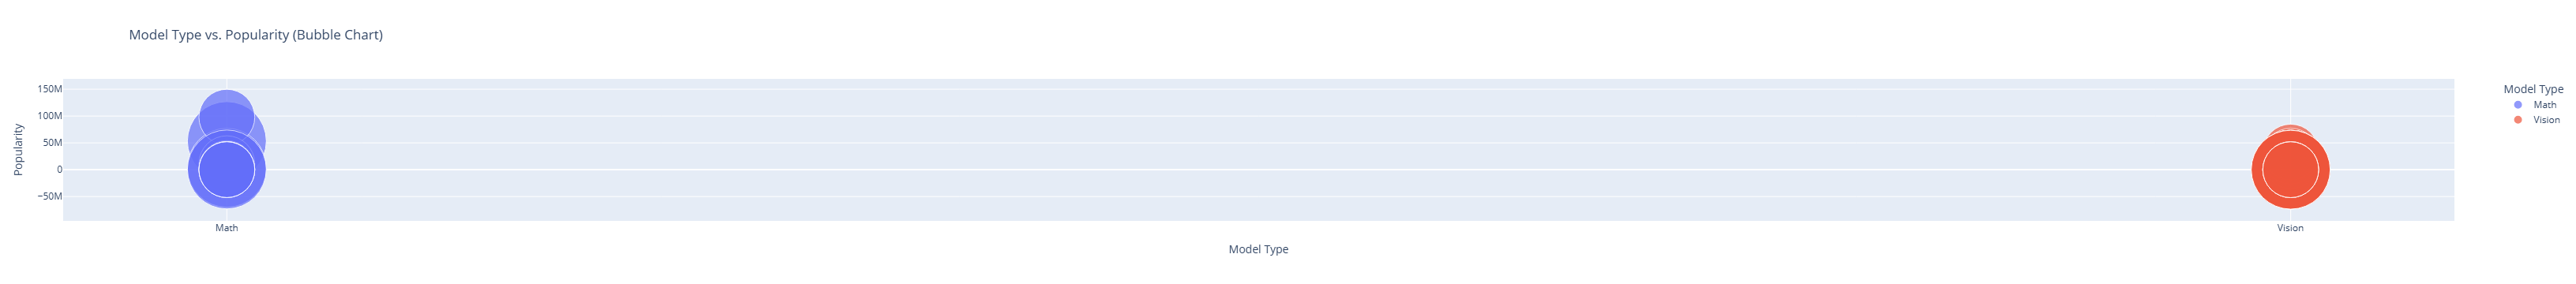

In [50]:
# List of model type columns
model_type_cols = [
    'model_type_math', 'model_type_vision', 'model_type_text',
    'model_type_embedding', 'model_type_reasoning', 'model_type_chat', 'model_type_code'
]

# Assign each model its primary type (first True/1 value)
def get_primary_type(row):
    for col in model_type_cols:
        if row[col] == 1:
            return col.replace('model_type_', '').capitalize()
    return 'Other'

df['primary_type'] = df.apply(get_primary_type, axis=1)

# Bubble chart: x = model type, y = popularity, size = capability_count
fig = px.scatter(
    df,
    x='primary_type',
    y='popularity',
    size='capability_count',
    color='primary_type',
    hover_name='name',
    title='Model Type vs. Popularity (Bubble Chart)',
    labels={'primary_type': 'Model Type', 'popularity': 'Popularity', 'capability_count': 'Capabilities'}
)
fig.update_traces(marker=dict(sizemode='area', sizeref=2.*max(df['capability_count'])/(100**2), line_width=1))
fig.show()

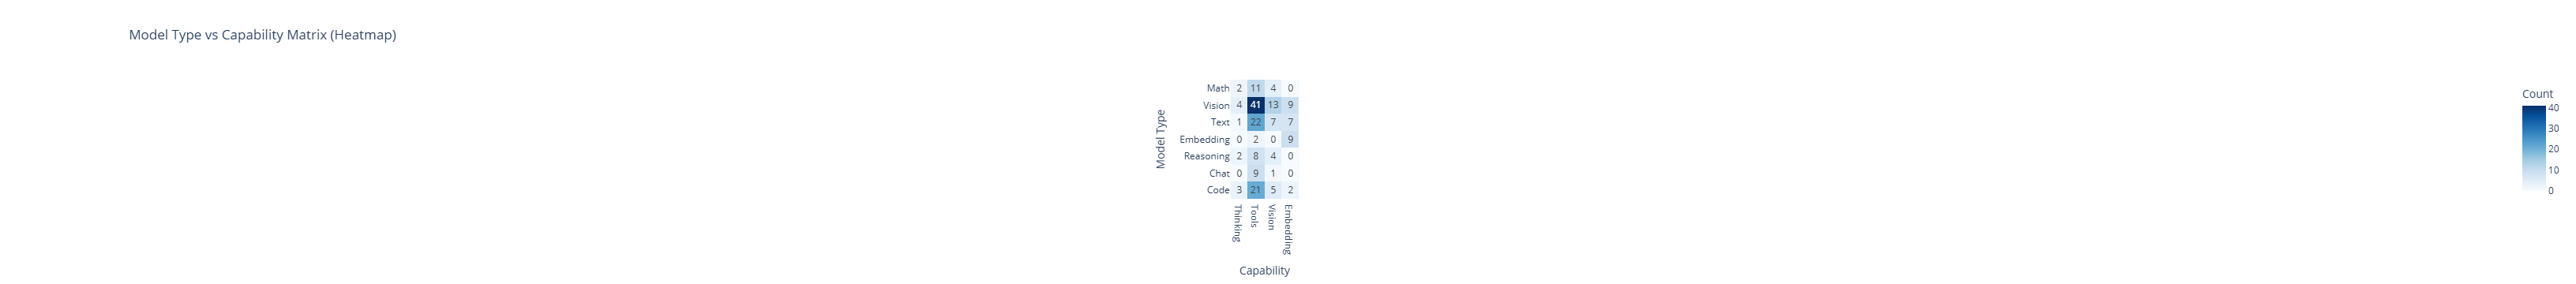

In [51]:
# List of model type and capability columns
model_type_cols = [
    'model_type_math', 'model_type_vision', 'model_type_text',
    'model_type_embedding', 'model_type_reasoning', 'model_type_chat', 'model_type_code'
]
capability_cols = [
    'capabilities_thinking', 'capabilities_tools', 'capabilities_vision', 'capabilities_embedding'
]

# Build the cross-tabulation matrix
matrix = pd.DataFrame(index=model_type_cols, columns=capability_cols)
for mt in model_type_cols:
    for cap in capability_cols:
        matrix.loc[mt, cap] = df[(df[mt] == 1) & (df[cap] == 1)].shape[0]

# Convert to numeric and prettify labels
matrix = matrix.astype(int)
matrix.index = [col.replace('model_type_', '').capitalize() for col in matrix.index]
matrix.columns = [col.replace('capabilities_', '').capitalize() for col in matrix.columns]

# Plotly heatmap
fig = px.imshow(
    matrix,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x="Capability", y="Model Type", color="Count"),
    title="Model Type vs Capability Matrix (Heatmap)"
)
fig.show()

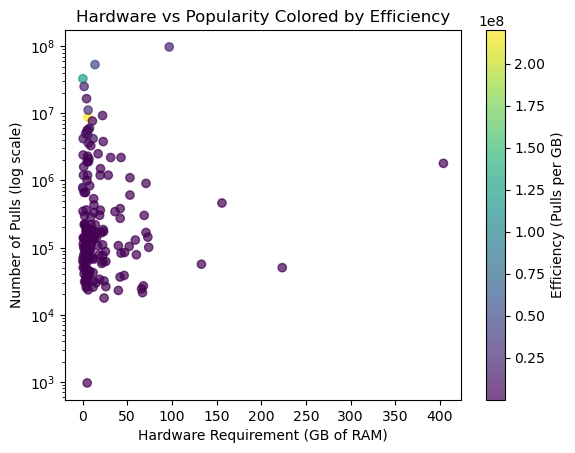

In [52]:
plt.scatter(df['hw_gb_mean'], df['pulls_num'],
            c=df['efficiency'], cmap='viridis', alpha=0.7)
plt.yscale('log')
plt.colorbar(label='Efficiency (Pulls per GB)')
plt.xlabel('Hardware Requirement (GB of RAM)')
plt.ylabel('Number of Pulls (log scale)')
plt.title('Hardware vs Popularity Colored by Efficiency')
plt.show()

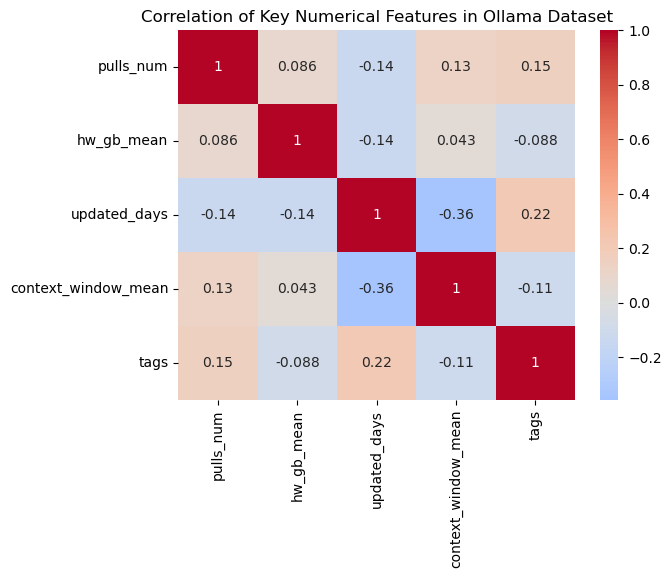

In [53]:
num_cols = ['pulls_num','hw_gb_mean',
            'updated_days','context_window_mean','tags']
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation of Key Numerical Features in Ollama Dataset')
plt.show()